# 1. Create the environment with Python 3.9
conda create -n TripleStreams python=3.9 -y

# 2. Activate it
conda activate TripleStreams

# 3. Install Jupyter + core dependencies
conda install -c conda-forge jupyterlab notebook ipykernel \
    numpy=1.26 scipy=1.11 pandas matplotlib seaborn tqdm plotly bokeh=2.4.3 ffmpeg -y

# 4. Install pip-only packages
pip install note-seq pydub wandb

# 5. Register environment as a Jupyter kernel
python -m ipykernel install --user --name=TripleStreams --display-name "Python (TripleStreams)"


In [1]:
import os
import pickle, bz2

import tqdm
from bokeh.io import output_notebook, show

try:
    import note_seq
    HAS_NOTE_SEQ = True
except:
    HAS_NOTE_SEQ = False

/Users/bezha/anaconda3/envs/TripleStreams/lib/python3.9/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# loader
import bz2, pickle

class NumpyCompatUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        # Redirect legacy/private numpy path to the public one
        if module == "numpy._core":
            module = "numpy.core"
        return super().find_class(module, name)

def load_dataset(file_path):
    with bz2.BZ2File(file_path, 'rb') as f:
        return NumpyCompatUnpickler(f).load()


def print_dataset_structure(dataset_dict, name=None):
    first_level_keys = set()
    second_level_keys = set()
    third_level_keys = set()



    for key, value in dataset_dict.items():
        first_level_keys.add(key)
        if isinstance(value, dict):
            for sub_key in value.keys():
                second_level_keys.add(sub_key)
                if isinstance(value[sub_key], dict):
                    for sub_sub_key in value[sub_key].keys():
                        third_level_keys.add(sub_sub_key)

    if name is not None:
        print(f"Dataset Structure for Dataset: {name}")
    else:
        print("Dataset Structure:")


    print("----"*10)
    print("First Level Keys:")
    print(first_level_keys)
    print("----"*10)
    print("Second Level Keys:")
    print(list(second_level_keys)[:10])
    print("----"*10)
    print("Third Level Keys:")
    print(third_level_keys)
    print("----"*10)
    print("\n")

def print_all_datasets_structure(dataset_path_list):
    for dataset_pkl in dataset_pkls:
        dataset_path = os.path.join(data_dir, dataset_pkl)
        dataset_dict = load_dataset(dataset_path)
        print_dataset_structure(dataset_dict, name=dataset_pkl)
        del dataset_dict

# get all split_n_bar_phrases from last key
def get_split_n_bar_phrases(dataset_path_list):
    if not isinstance(dataset_path_list, list):
        dataset_path_list = [dataset_path_list]

    split_n_bar_phrases = list()

    for dataset_pkl_ in dataset_path_list:
        dataset_dict_ = load_dataset(os.path.join(data_dir, dataset_pkl_))
        for key, value in dataset_dict_.items():
            for sub_key, sub_value in value.items():
                hvo_splits = sub_value['split_n_bar_phrases']
                for hvo_split in hvo_splits:
                    hvo_split.metadata.update({'collection': dataset_pkl_.replace('.pkl.bz2', ''), 'sample_id': sub_key})

                split_n_bar_phrases.extend(sub_value['split_n_bar_phrases'])

    return split_n_bar_phrases

import random

def get_randome_phrases(split_n_bar_phrases, n=1):
    # returns hvos and their indexes in the split_n_bar_phrases list
    if not isinstance(split_n_bar_phrases, list):
        split_n_bar_phrases = [split_n_bar_phrases]
    sample_ix = random.sample(range(len(split_n_bar_phrases)), n)
    sample_hvo_phrases = [split_n_bar_phrases[ix] for ix in sample_ix]

    return sample_hvo_phrases, sample_ix


# version-safe imports
from bokeh.io import output_notebook, show
try:
    # Bokeh ≥ 3.0
    from bokeh.models import Tabs, TabPanel as Panel
    HAS_TABPANEL = True
except ImportError:
    # Bokeh 2.x (your case: 2.4.3)
    from bokeh.models.widgets import Tabs, Panel
    HAS_TABPANEL = False


import warnings
import logging
from bokeh.util.warnings import BokehUserWarning, BokehDeprecationWarning

def setup_quiet_bokeh():
    """Set up comprehensive bokeh warning suppression"""
    # Suppress warnings
    warnings.filterwarnings("ignore", category=BokehUserWarning)
    warnings.filterwarnings("ignore", category=BokehDeprecationWarning)
    warnings.filterwarnings("ignore", message=".*bokeh.*")

    # Suppress logging
    logging.getLogger('bokeh').setLevel(logging.ERROR)

    # Suppress other common warnings that might appear with bokeh
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

def create_multitab_from_figures(hvos,  tab_titles=None, show_tabs= True):
    """
    Create a multitab visualizer from already-generated bokeh figures.

    Parameters:
    -----------
    figures : List
        List of bokeh figure objects
    tab_titles : List[str]
        List of titles for each tab
    show_tabs : bool, default=True
        Whether to immediately show the tabs

    Returns:
    --------
    Tabs
        Bokeh Tabs object containing all the figures
    """
    setup_quiet_bokeh()
    output_notebook()

    figures = []

    generate_titles = False
    if tab_titles is None:
        tab_titles = []
        generate_titles = True

    if not isinstance(hvos, list):
        hvos = [hvos]
    for ix, hvo in enumerate(hvos):
        figure = hvo.to_html_plot(
            filename='',
            save_figure=False,
            show_figure=False)
        figures.append(figure)
        if generate_titles:
            tab_titles.append(f"Tab {ix+1}")

    if not isinstance(tab_titles, list):
        tab_titles = [tab_titles]
    if not tab_titles:
        tab_titles = [f"Tab {i+1}" for i in range(len(figures))]
    if len(figures) == 0:
        raise ValueError("No figures provided to create tabs")

    if len(figures) != len(tab_titles):
        raise ValueError("Number of figures must match number of tab titles")

    panels = []

    for figure, title in zip(figures, tab_titles):
        panel = TabPanel(child=figure, title=title) if HAS_TABPANEL else Panel(child=figure, title=title)
        panels.append(panel)

    tabs = Tabs(tabs=panels)

    if show_tabs:
        show(tabs)

    return tabs




In [3]:
# LOAD DATASETS
import os, pickle, bz2

data_dir = "data/triple_streams/split_2bars/rest" # "data/triple_streams/split_2bars/lmd or rest"

# find all .pkl.bz2 files in the directory
# dataset_pkls = [f for f in os.listdir(data_dir) if f.endswith('.pkl.bz2')]
dataset_pkls = ['groove_midi.pkl.bz2']
# print the structure of each dataset
print_all_datasets_structure(dataset_pkls)

# load all loops from all datasets
split_n_bar_phrases = get_split_n_bar_phrases(dataset_pkls)

# print the number of phrases loaded
print(f"Number of split_n_bar_phrases loaded: {len(split_n_bar_phrases)}")


Could not import fluidsynth. AUDIO rendering will not work.


Dataset Structure for Dataset: groove_midi.pkl.bz2
----------------------------------------
First Level Keys:
{'velocity', 'pitch', 'toms', 'functional', 'functionalhats'}
----------------------------------------
Second Level Keys:
['19_jazz_120_beat_4-4', '16_rock_100_beat_4-4', '44_rock_120_beat_4-4', '4_rock_105_beat_4-4', '132_soul_105_beat_4-4', '1_funk-groove1_138_beat_4-4', '9_rock_135_beat_4-4', '188_reggae_78_fill_4-4', '35_rock_120_beat_4-4', '37_hiphop_100_fill_4-4']
----------------------------------------
Third Level Keys:
{'split_n_bar_phrases', 'hvo_sequences', 'compiled_single_hvo', 'filenames'}
----------------------------------------


Number of split_n_bar_phrases loaded: 82687


In [4]:
# INSPECT SOME HVO SAMPLES
create_multitab_from_figures(split_n_bar_phrases[2000:2010], show_tabs=True)


Loading BokehJS ...

Tabs(id='2623', ...)

In [14]:
import numpy as np
try:
    import seaborn as sns
    HAVE_SEABORN = True
except ModuleNotFoundError:
    HAVE_SEABORN = False

try:
    import matplotlib.pyplot as plt
    HAS_MATPLOT = True
except:
    HAS_MATPLOT = False

def get_accent_hits_from_velocities(velocity_flat, accent_thresh=0.75, compare_consecutives=False):
    """
    Extract accent hits from the velocity flat representation of HVO.
    :param velocity_flat: a (B, T, 1) or (T, 1) numpy array where the last  column represents the velocity of hits.
    :param use_median: if True, use the median velocity to determine accent hits, otherwise use 0.5
    :return:
    """
    assert velocity_flat.ndim == 1 or velocity_flat.shape[-1] == 1, "Velocity flat must have 1 columns (hits, velocity, offset)"

    return np.where(velocity_flat > accent_thresh, 1, 0)

def get_split_to_streams(hvo_sample, groove_dim=0):
    """
    Split the HVO sample into input groove, streams, and flat output HVO.

    Parameters:
    -----------
    hvo_sample : HVOSequence
        The HVO sample to be split.
    groove_dim : int, optional
        The index of the groove dimension in the HVO sample. Default is 0.

    Returns:
    --------
    input_hvo : HVOSequence
        The input groove extracted from the HVO sample.
    streams : list of HVOSequence
        List of streams extracted from the HVO sample, excluding the groove dimension.
    flat_out_hvo : HVOSequence
        The flat output HVO sequence with the groove dimension set to zero.
    """
    # get input groove
    n_streams = hvo_sample.hits.shape[1]

    input_hvo = hvo_sample.hvo[:, (groove_dim, groove_dim+n_streams, groove_dim+2*n_streams)]

    # get flat of rest
    flat_hvo = hvo_sample.copy()
    flat_hvo.hvo[:, groove_dim] = 0                             # remove groove hit
    flat_hvo.hvo[:, (groove_dim + n_streams)] = 0               # remove groove vel
    flat_hvo.hvo[:, (groove_dim + n_streams*2)] = 0             # remove groove offset
    flat_out_hvo  = flat_hvo.flatten_voices(reduce_dim=True)

    # streams
    streams = []
    for i in range(n_streams):
        if i != groove_dim:
            streams.append(hvo_sample.hvo[:, (i, i+n_streams, i+2*n_streams)])

    return input_hvo, streams, flat_out_hvo

def Jaccard_similarity(a, b):
    intersection = np.sum(np.minimum(a, b))
    union = np.sum(np.maximum(a, b))
    return (intersection / union)

def hamming_distance(a, b):
    if len(a) != len(b):
        raise ValueError("Sequences must be of equal length")
    return sum(x != y for x, y in zip(a, b))/ len(a)

from hvo_sequence.utils import fuzzy_Hamming_distance

def extract_features_from_sets(hvo_sample, groove_dim):
    """
    Extract control features from a set of HVO samples.
    :param hvo_sample: HVOSequence
        The HVO sample to extract control features from.
    :param groove_dim: int
        The index of the groove dimension in the HVO sample.
    :return: dict
        A dictionary containing the control features.
    """
    input_hvo, out_streams, flat_out_hvo = get_split_to_streams(hvo_sample, groove_dim=groove_dim)

    input_hits = input_hvo[:, 0]
    flat_out_hits = flat_out_hvo[:, 0]
    analysis_dict = {
        "groove_to_output_hit_hamming_distance": float(hamming_distance(input_hits, flat_out_hits)),
    }

    input_velocities = input_hvo[:, 1]
    input_accent_hits = get_accent_hits_from_velocities(input_velocities)
    flat_out_velocities = flat_out_hvo[:, 1]
    flat_out_accent_hits = get_accent_hits_from_velocities(flat_out_velocities)
    analysis_dict.update({
        "groove_to_output_accent_hamming_distance": float(hamming_distance(input_accent_hits, flat_out_accent_hits)),
    })

    # calculate hit
    analysis_dict.update({f"out_stream_{i}_jaccard_sim_with_flat_out": float(Jaccard_similarity(out_streams[i][:, 0], flat_out_hits)) for i in range(len(out_streams))})
    analysis_dict.update({f"out_stream_{i}_accent_hamming_distance_with_flat_out": float(hamming_distance(get_accent_hits_from_velocities(out_streams[i][:, 1]), flat_out_accent_hits)) for i in range(len(out_streams))})


    return analysis_dict

# plot violin plots of the control features

def plot_control_features_violin(control_features_df):
    """
    Plot violin plots of the control features.
    :param control_features_df: pd.DataFrame
        DataFrame containing the control features.
    """
        
    plt.figure(figsize=(6, 8))
    sns.violinplot(data=control_features_df.drop(columns=["sample_id", "collection"]))
    # 90 deg rotate with wrapp
    plt.xticks(rotation=90, fontsize=8)
    plt.title("Control Features Violin Plots")
    plt.tight_layout()


    plt.show()

# plot the  scatter of groove to output hit hamming distance and groove to output accent hamming distance
def plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=False):
    if not HAS_MATPLOT: return
    plt.figure(figsize=(6, 4))
    x = control_features_df["groove_to_output_hit_hamming_distance"]
    y = control_features_df["groove_to_output_accent_hamming_distance"] if not use_normalized_accents else control_features_df["accent_hamming_values_per_hit_hamming_normalized"]
    plt.scatter(x, y, alpha=0.005)
    plt.xlabel("Groove to Output Hit Hamming Distance")
    plt.ylabel("Groove to Output Accent Hamming Distance")
    if use_normalized_accents:
        plt.title("Scatter Plot of Groove to Output Hit and Binned Accent Hamming Distances")
    else:
        plt.title("Scatter Plot of Groove to Output Hit and Accent Hamming Distances")
    plt.tight_layout()
    plt.show()



In [15]:
split_n_bar_phrases[0].metadata

{'track_number': '40',
 'genre': 'latin-samba',
 'bpm': '116',
 'meter': '4-4',
 'grouping': 'velocity',
 'member': 'groove',
 'source': 'GrooveMIDI',
 'stream_0': 'low',
 'stream_1': 'mid',
 'stream_2': 'high',
 'stream_3': 'groove',
 'start_bar': 0,
 'collection': 'groove_midi',
 'sample_id': '40_latin-samba_116_fill_4-4'}

In [16]:
hvo_samples, sample_indices = get_randome_phrases(split_n_bar_phrases, n=1)
create_multitab_from_figures(hvo_samples, [f"ix: {ix}" for ix in sample_indices], show_tabs=True)
extract_features_from_sets(hvo_samples[0], groove_dim=0)

Loading BokehJS ...

{'groove_to_output_hit_hamming_distance': 0.53125,
 'groove_to_output_accent_hamming_distance': 0.0,
 'out_stream_0_jaccard_sim_with_flat_out': 0.0,
 'out_stream_1_jaccard_sim_with_flat_out': 1.0,
 'out_stream_2_jaccard_sim_with_flat_out': 0.0,
 'out_stream_0_accent_hamming_distance_with_flat_out': 0.0,
 'out_stream_1_accent_hamming_distance_with_flat_out': 0.0,
 'out_stream_2_accent_hamming_distance_with_flat_out': 0.0}

In [17]:
# Extract control features for all samples
control_features = {
    "sample_id": [],
    "collection": [],
}
import tqdm

for hvo_sample in tqdm.tqdm(split_n_bar_phrases):
    for groove_dim in range(4): #<--- change to 1 if you don't want to use all streams as a groove (TODO: Change and generate different plots)
        control_features["sample_id"].append(hvo_sample.metadata['sample_id'])
        control_features["collection"].append(hvo_sample.metadata['collection'])

        features = extract_features_from_sets(hvo_sample, groove_dim)
        for key, value in features.items():
            if key not in control_features:
                control_features[key] = []
            control_features[key].append(value)



# Convert to DataFrame
import pandas as pd
control_features_df = pd.DataFrame(control_features)
control_features_df

 50%|█████     | 41419/82687 [00:28<00:28, 1460.36it/s]/var/folders/lr/8ctpqx7n6m54ydpt525nf6q80000gn/T/ipykernel_4893/4236917185.py:68: RuntimeWarning: invalid value encountered in scalar divide
  return (intersection / union)
100%|██████████| 82687/82687 [00:56<00:00, 1463.85it/s]


,sample_id,collection,groove_to_output_hit_hamming_distance,groove_to_output_accent_hamming_distance,out_stream_0_jaccard_sim_with_flat_out,out_stream_1_jaccard_sim_with_flat_out,out_stream_2_jaccard_sim_with_flat_out,out_stream_0_accent_hamming_distance_with_flat_out,out_stream_1_accent_hamming_distance_with_flat_out,out_stream_2_accent_hamming_distance_with_flat_out
0,40_latin-samba_116_fill_4-4,groove_midi,0.21875,0.0000,0.300000,0.700000,1.000000,0.00000,0.00000,0.00000
1,40_latin-samba_116_fill_4-4,groove_midi,0.21875,0.0000,0.300000,0.700000,1.000000,0.00000,0.00000,0.00000
2,40_latin-samba_116_fill_4-4,groove_midi,0.09375,0.0000,0.300000,0.300000,1.000000,0.00000,0.00000,0.00000
3,40_latin-samba_116_fill_4-4,groove_midi,0.00000,0.0000,0.300000,0.300000,0.700000,0.00000,0.00000,0.00000
4,26_hiphop_100_fill_4-4,groove_midi,0.21875,0.0000,1.000000,0.235294,0.352941,0.00000,0.12500,0.12500
...,...,...,...,...,...,...,...,...,...,...
330743,28_latin-bounce_106_beat_4-4,groove_midi,0.53125,0.0625,0.000000,0.100000,0.900000,0.06250,0.03125,0.03125
330744,28_latin-bounce_106_beat_4-4,groove_midi,0.53125,0.1250,0.058824,0.529412,0.411765,0.09375,0.09375,0.06250
330745,28_latin-bounce_106_beat_4-4,groove_midi,0.53125,0.1250,0.000000,0.562500,0.437500,0.09375,0.06250,0.03125
330746,28_latin-bounce_106_beat_4-4,groove_midi,0.53125,0.1250,0.000000,0.125000,0.875000,0.09375,0.06250,0.03125


In [18]:
import numpy as np
# box plot import

n_bins = 10
valid_values = np.linspace(0, 1, n_bins)
# get unique hit hamming distances
hit_hamming_values = sorted(set(control_features_df["groove_to_output_hit_hamming_distance"].values))

accent_hamming_values_per_hit_hamming = {float(hit_hamming_value): [] for hit_hamming_value in hit_hamming_values}
for key in accent_hamming_values_per_hit_hamming.keys():
    accent_hamming_values_per_hit_hamming[key] = control_features_df[control_features_df["groove_to_output_hit_hamming_distance"] == key].groove_to_output_accent_hamming_distance.values
    # get box plot stats
    lower_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[10]
    upper_bound = min(np.sort(accent_hamming_values_per_hit_hamming[key])[-20], 1.0)  # upper bound is the 20th largest value or 1.0

    if "accent_hamming_values_per_hit_hamming_normalized" not in control_features_df.columns:
        control_features_df["accent_hamming_values_per_hit_hamming_normalized"] = np.nan

    # strech so that lower bound is 0 and upper bound is 1, then clip to 0-1 range
    if lower_bound < 0.1:
        lower_bound = 0.
    control_features_df.loc[control_features_df["groove_to_output_hit_hamming_distance"] == key, "accent_hamming_values_per_hit_hamming_normalized"] = \
        np.clip((control_features_df.loc[control_features_df["groove_to_output_hit_hamming_distance"] == key, "groove_to_output_accent_hamming_distance"] - lower_bound) / (upper_bound - lower_bound), 0, 1)

# change normalized values to the closest valid value
control_features_df["accent_hamming_values_per_hit_hamming_normalized"] = control_features_df["accent_hamming_values_per_hit_hamming_normalized"].apply(
    lambda x: valid_values[np.argmin(np.abs(valid_values - x))] if not np.isnan(x) else np.nan)
# print the first 10 rows of the control features DataFrame

# print new normalized column, vs original
control_features_df[["groove_to_output_hit_hamming_distance", "groove_to_output_accent_hamming_distance", "accent_hamming_values_per_hit_hamming_normalized"]].head(10)


,groove_to_output_hit_hamming_distance,groove_to_output_accent_hamming_distance,accent_hamming_values_per_hit_hamming_normalized
0,0.21875,0.000,0.000000
1,0.21875,0.000,0.000000
2,0.09375,0.000,0.000000
3,0.00000,0.000,0.000000
4,0.21875,0.000,0.000000
5,0.00000,0.000,0.000000
6,0.40625,0.125,0.222222
7,0.34375,0.125,0.222222
8,0.31250,0.125,0.222222
9,0.15625,0.125,0.333333


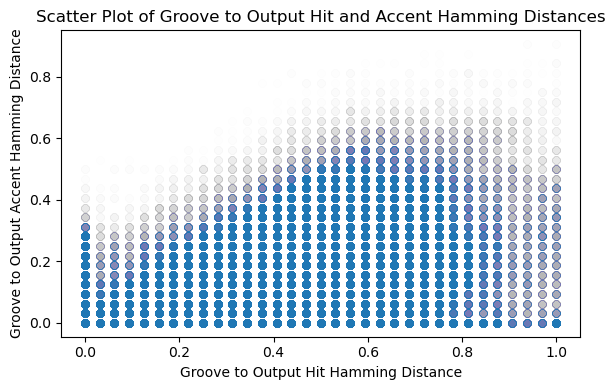

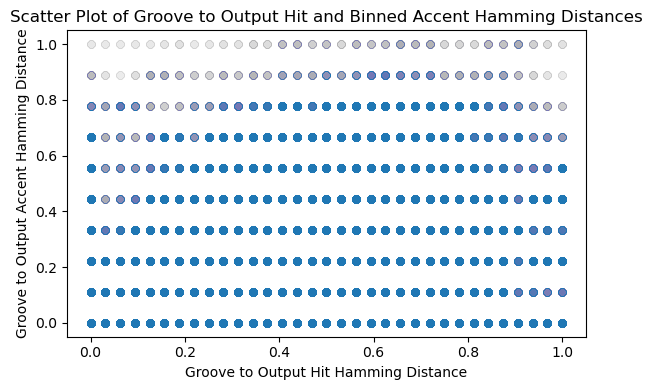

In [19]:
plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=False)
plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=True)

Available collections: ['groove_midi']


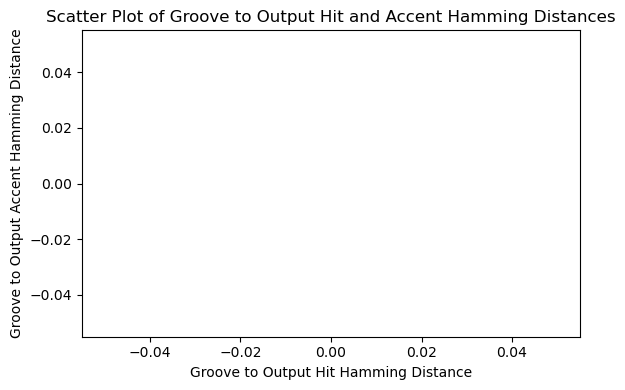

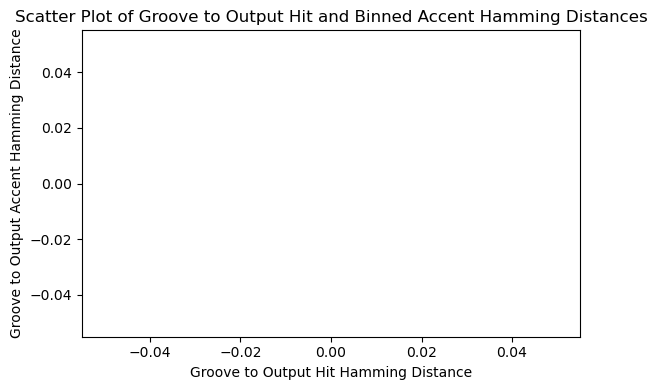

In [20]:

# get all available collections
collections = control_features_df["collection"].unique()
print(f"Available collections: {collections}")
# exclude groove_midi
df_subset = control_features_df[control_features_df["collection"] == "lmd_batch_60"]
plot_scatter_input_output_distribution(df_subset, use_normalized_accents=False)
df_subset = control_features_df[control_features_df["collection"] == "lmd_batch_60"]
plot_scatter_input_output_distribution(df_subset, use_normalized_accents=True)
# df_subset = control_features_df[control_features_df["collection"] == "elbg"]
# plot_scatter_input_output_distribution(df_subset, use_normalized_accents=False)
# df_subset = control_features_df[control_features_df["collection"] == "candombe"]
# plot_scatter_input_output_distribution(df_subset, use_normalized_accents=False)
# df_subset = control_features_df[control_features_df["collection"] == "taptamdrum_hvo_output_both_is_and"]
# plot_scatter_input_output_distribution(df_subset, use_normalized_accents=False)
# df_subset = control_features_df[control_features_df["collection"] == "groove_midi"]
# plot_scatter_input_output_distribution(df_subset, use_normalized_accents=False)


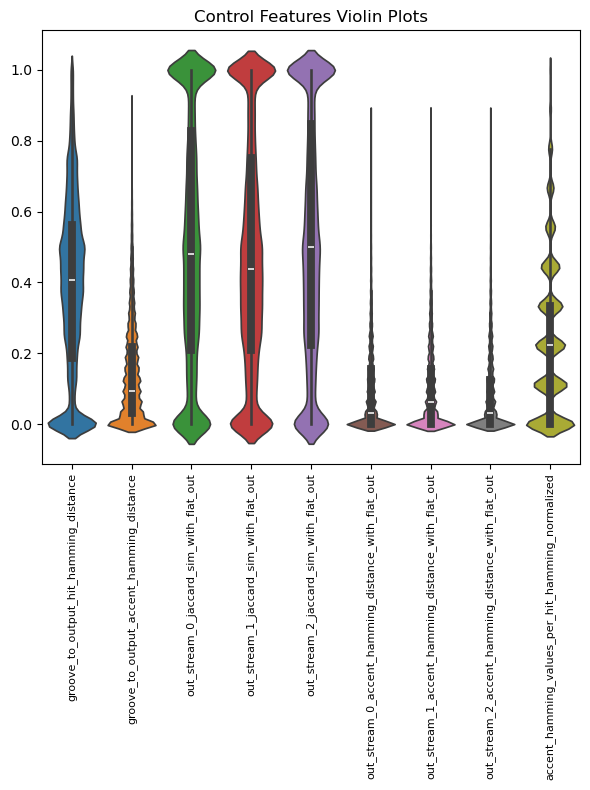

In [21]:
plot_control_features_violin(control_features_df)


In [22]:
# plot histogram of Accent hamming for hit distance of n (actual distance will be n*1./31.)
def plot_histogram_accent_hamming_distance(control_features_df, hit_hamming_distance_index=0):
    """
    Plot histogram of accent hamming distance for hit distance of n (actual distance will be n*1./32.)
    :param control_features_df: pd.DataFrame
        DataFrame containing the control features.
    :param hit_hamming_distance_index: int
        The index of the hit hamming distance to plot.
    """
    plt.figure(figsize=(6, 4))
    hit_hamming_distance = control_features_df["groove_to_output_hit_hamming_distance"]
    accent_hamming_distance = control_features_df["groove_to_output_accent_hamming_distance"]

    plt.hist(accent_hamming_distance[hit_hamming_distance == hit_hamming_distance_index/32.0], bins=30, alpha=0.7)
    plt.xlabel("Accent Hamming Distance")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Accent Hamming Distance for Hit Distance {hit_hamming_distance_index}")
    plt.tight_layout()
    plt.show()

# create a grid of 4 x 8 figures with the histogram of accent hamming distance for hit distance of n (actual distance will be n*1./32.)
def plot_histogram_accent_hamming_distance_grid(control_features_df, hit_hamming_distance_index=0):
    """
    Plot histogram of accent hamming distance for hit distance of n (actual distance will be n*1./32.)
    :param control_features_df: pd.DataFrame
        DataFrame containing the control features.
    :param hit_hamming_distance_index: int
        The index of the hit hamming distance to plot.
    """
    fig, axs = plt.subplots(4, 8, figsize=(16, 8))
    axs = axs.flatten()

    for i in range(32):
        hit_hamming_distance = control_features_df["groove_to_output_hit_hamming_distance"]
        accent_hamming_distance = control_features_df["groove_to_output_accent_hamming_distance"]

        axs[i].hist(accent_hamming_distance[hit_hamming_distance == i/32.0], bins=30, alpha=0.7)
        axs[i].set_xlabel("Accent Hamming Distance")
        axs[i].set_ylabel("Frequency")
        axs[i].set_title(f"Hit Distance {i}")

    plt.tight_layout()
    plt.show()

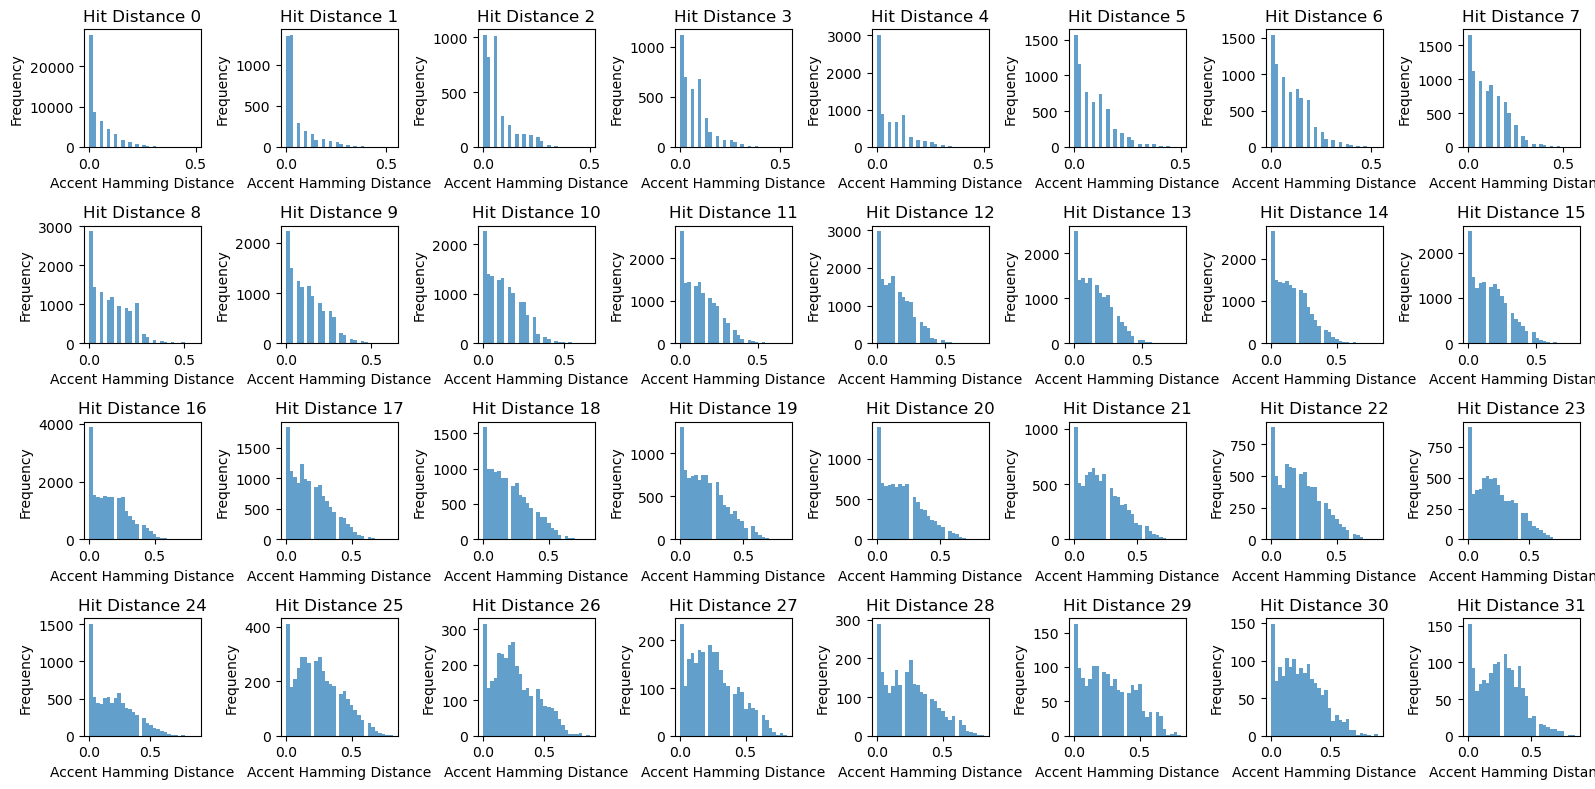

In [23]:

plot_histogram_accent_hamming_distance_grid(control_features_df, hit_hamming_distance_index=32)


In [24]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

def create_heatmap_histogram(df, key1, key2, bins=None, title=None, exclude_pairs=None,
                           show_zeros=False):
    """
    Creates an interactive heatmap histogram from a DataFrame using two keys.
    Shows frequency counts in each cell like a confusion matrix.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe
    key1 : str
        Column name for x-axis
    key2 : str
        Column name for y-axis
    bins : int, tuple, or None, optional
        Number of bins for each dimension. If None (default), uses all unique values
    title : str, optional
        Plot title (default: auto-generated)
    exclude_pairs : list of tuples or tuple, optional
        Specific (key1, key2) value pairs to exclude from calculations
        e.g., [(10, 20), (15, 25)] or (10, 20) for single exclusion
    show_zeros : bool, optional
        Whether to show 0 counts in cells (default: False)

    Returns:
    --------
    plotly.graph_objects.Figure
        Interactive heatmap with counts
    """

    # Create a copy to avoid modifying original dataframe
    df_filtered = df.copy()

    # Handle exclusions
    if exclude_pairs is not None:
        # Convert single tuple to list of tuples
        if isinstance(exclude_pairs, tuple):
            exclude_pairs = [exclude_pairs]

        # Create boolean mask for rows to keep
        mask = pd.Series([True] * len(df_filtered), index=df_filtered.index)

        for pair in exclude_pairs:
            if len(pair) != 2:
                raise ValueError("Each exclusion pair must contain exactly 2 values")

            exclude_mask = (df_filtered[key1] == pair[0]) & (df_filtered[key2] == pair[1])
            mask = mask & ~exclude_mask

            # Print info about excluded points
            excluded_count = exclude_mask.sum()
            if excluded_count > 0:
                print(f"Excluded {excluded_count} points with ({key1}={pair[0]}, {key2}={pair[1]})")

        # Apply the mask
        df_filtered = df_filtered[mask]
        print(f"Total rows after exclusions: {len(df_filtered)} (original: {len(df)})")

    # Extract data for the two keys and remove NaN values
    valid_data = df_filtered[[key1, key2]].dropna()
    x_data = valid_data[key1]
    y_data = valid_data[key2]

    if len(x_data) == 0:
        print("Warning: No valid data points remaining after exclusions and NaN removal")
        return None

    # Handle bins=None case (use unique values)
    if bins is None:
        # Create cross-tabulation using unique values
        crosstab = pd.crosstab(y_data, x_data, dropna=False)

        # Get sorted unique values for consistent ordering
        x_values = sorted(x_data.unique())
        y_values = sorted(y_data.unique())

        # Reindex to ensure all values are present
        crosstab = crosstab.reindex(index=y_values, columns=x_values, fill_value=0)

        # Create labels (convert to string for display)
        x_labels = [str(x) for x in x_values]
        y_labels = [str(y) for y in y_values]

        # Get the count matrix
        count_matrix = crosstab.values

    else:
        # Use binning approach for numeric bins
        # Create 2D histogram using numpy
        hist, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=bins)

        # Create bin labels for better readability
        x_labels = []
        for i in range(len(x_edges) - 1):
            x_labels.append(f"{x_edges[i]:.1f}-{x_edges[i+1]:.1f}")

        y_labels = []
        for i in range(len(y_edges) - 1):
            y_labels.append(f"{y_edges[i]:.1f}-{y_edges[i+1]:.1f}")

        # Transpose histogram for correct orientation
        count_matrix = hist.T

    # Create text annotations for each cell (showing the count)
    text_annotations = []
    for i in range(len(y_labels)):
        row = []
        for j in range(len(x_labels)):
            count = int(count_matrix[i, j])
            if count > 0 or show_zeros:
                row.append(str(count))
            else:
                row.append("")  # Don't show 0s for cleaner look unless requested
        text_annotations.append(row)

    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
        z=count_matrix,
        x=x_labels,
        y=y_labels,
        text=text_annotations,
        texttemplate="%{text}",
        textfont={"size": max(8, min(12, 300 // max(len(x_labels), len(y_labels))))},  # Dynamic font size
        colorscale='Plasma', # 'YlGnBu', 'Cividis', 'Plasma', 'Inferno', 'Magma'
        showscale=True,
        colorbar=dict(title="Count"),
        hovertemplate=f'{key1}: %{{x}}<br>{key2}: %{{y}}<br>Count: %{{z}}<extra></extra>'
    ))

    # Update layout
    if title is None:
        exclusion_info = f" (Excluded {len(exclude_pairs)} pairs)" if exclude_pairs else ""
        bins_info = "All unique values" if bins is None else f"{bins} bins"
        title = f'Heatmap: {key1} vs {key2} ({bins_info}){exclusion_info}'

    # Dynamic sizing based on number of categories
    plot_width = max(600, len(x_labels) * 40)
    plot_height = max(400, len(y_labels) * 30)

    fig.update_layout(
        title=title,
        xaxis_title=key1,
        yaxis_title=key2,
        width=min(plot_width, 1200),  # Cap maximum width
        height=min(plot_height, 800), # Cap maximum height
        xaxis=dict(tickangle=45 if len(x_labels) > 10 else 0),
        yaxis=dict(tickangle=0)
    )

    return fig

def create_binned_heatmap_histogram(df, key1, key2, bins=20, title=None, exclude_pairs=None,
                                  show_zeros=False):
    """
    Creates a heatmap for continuous data with explicit binning.
    This is the old behavior when you specifically want to bin continuous data.

    Parameters are the same as create_heatmap_histogram but bins defaults to 20.
    """
    return create_heatmap_histogram(df, key1, key2, bins=bins, title=title,
                                  exclude_pairs=exclude_pairs, show_zeros=show_zeros)

# Helper function to check data characteristics
def analyze_data_for_binning(df, key1, key2):
    """
    Analyzes the data to suggest whether binning might be needed.

    Returns:
    --------
    dict: Information about the data characteristics
    """
    x_data = df[key1].dropna()
    y_data = df[key2].dropna()

    x_unique_count = x_data.nunique()
    y_unique_count = y_data.nunique()

    x_is_numeric = pd.api.types.is_numeric_dtype(x_data)
    y_is_numeric = pd.api.types.is_numeric_dtype(y_data)

    analysis = {
        'x_unique_count': x_unique_count,
        'y_unique_count': y_unique_count,
        'x_is_numeric': x_is_numeric,
        'y_is_numeric': y_is_numeric,
        'total_combinations': x_unique_count * y_unique_count,
        'data_points': len(df[[key1, key2]].dropna())
    }

    # Suggestions
    if analysis['total_combinations'] > 100:
        analysis['suggestion'] = f"Consider using bins (e.g., bins=20) as you have {analysis['total_combinations']} unique combinations"
    elif analysis['total_combinations'] > 50:
        analysis['suggestion'] = "Data might benefit from binning for cleaner visualization"
    else:
        analysis['suggestion'] = "Using unique values (bins=None) should work well"

    return analysis

# Example usage:
"""
import pandas as pd
import numpy as np

# Example 1: Discrete/Categorical data (bins=None works great)
np.random.seed(42)
df_discrete = pd.DataFrame({
    'department': np.random.choice(['Sales', 'Engineering', 'Marketing', 'HR'], 500),
    'rating': np.random.choice([1, 2, 3, 4, 5], 500),
    'experience': np.random.choice(['Junior', 'Mid', 'Senior'], 500)
})

# This will use all unique values automatically
fig1 = create_heatmap_histogram(df_discrete, 'department', 'rating',
                               title='Department vs Rating (All Unique Values)')
fig1.show()

# Example 2: Continuous data with bins=None (might create many unique values)
df_continuous = pd.DataFrame({
    'height': np.random.normal(170, 10, 1000),
    'weight': np.random.normal(70, 15, 1000),
    'age': np.random.randint(18, 80, 1000)
})

# Check data characteristics first
analysis = analyze_data_for_binning(df_continuous, 'height', 'weight')
print("Data analysis:", analysis)

# This might create a very sparse heatmap due to many unique float values
fig2 = create_heatmap_histogram(df_continuous, 'height', 'weight',
                               title='Height vs Weight (All Unique Values - Might be Sparse)')

# Better approach for continuous data - use binning
fig3 = create_heatmap_histogram(df_continuous, 'height', 'weight', bins=15,
                               title='Height vs Weight (15x15 bins)')
fig3.show()

# Example 3: Integer data works well with bins=None
df_integers = pd.DataFrame({
    'score1': np.random.randint(0, 11, 1000),  # 0-10 score
    'score2': np.random.randint(0, 11, 1000),  # 0-10 score
    'category': np.random.choice(['A', 'B', 'C'], 1000)
})

fig4 = create_heatmap_histogram(df_integers, 'score1', 'score2',
                               title='Score1 vs Score2 (Integer Values)')
fig4.show()

# Example 4: With exclusions
fig5 = create_heatmap_histogram(df_discrete, 'department', 'rating',
                               exclude_pairs=[('Sales', 5), ('HR', 1)],
                               show_zeros=True,
                               title='Department vs Rating (With Exclusions)')
fig5.show()
"""

create_heatmap_histogram(control_features_df,
                         key1="groove_to_output_hit_hamming_distance",
                         key2="groove_to_output_accent_hamming_distance",
                         bins=None,
                         title="Heatmap Histogram of Groove to Output Hit Hamming Distance vs Accent Hamming Distance",
                         )




In [26]:
create_heatmap_histogram(control_features_df,
                         key1="groove_to_output_hit_hamming_distance",
                         key2="accent_hamming_values_per_hit_hamming_normalized",
                         bins=None,
                         title="Heatmap Histogram of Groove to Output Hit Hamming Distance vs Modified Accent Hamming Distance",
                         )

In [3]:


# Example usage and demonstrations
if __name__ == "__main__":
    # Test strings
    long_strings = [
        "This is a very long string that needs to be hashed into a shorter name",
        "SELECT * FROM users WHERE age > 25 AND status = 'active' ORDER BY created_date DESC",
        "feature_engineering_pipeline_with_categorical_encoding_and_normalization_v2_final",
        "https://api.example.com/v1/users/12345/posts?limit=50&offset=0&sort=date_desc"
    ]

    print("\n=== REPRODUCIBILITY TEST ===")
    print(f"Test string: {long_strings[0]}")
    for i in range(3):
        hash_result = hash_string_to_name(long_strings[0])
        print(f"Run {i+1}: {hash_result}")
    print("✓ All runs should produce identical results")


=== REPRODUCIBILITY TEST ===
Test string: This is a very long string that needs to be hashed into a shorter name
Run 1: 0600c911
Run 2: 0600c911
Run 3: 0600c911
✓ All runs should produce identical results
